In [27]:
import os
import importlib.util
import math

import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt 

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import load_data, feature_names
from data.hlf_preprocessing import HLFDataPreprocessor, load


In [36]:
#paths
result_path = '/home/oliverkn/pro/results/4_4/alad/33/'
data_path = '/home/oliverkn/pro/data/hlf_set'
config_file = result_path + 'config.py'
weights_file = result_path + 'model-200000'

max_samples = 500_000

# loading config
spec = importlib.util.spec_from_file_location('config', config_file)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# loading alad
tf.reset_default_graph()
ad = ALAD(config, tf.Session())
ad.load(weights_file)


loading data
data shape:(5935040, 23)
taking subset
data shape:(500000, 23)
running data preprocessor


/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


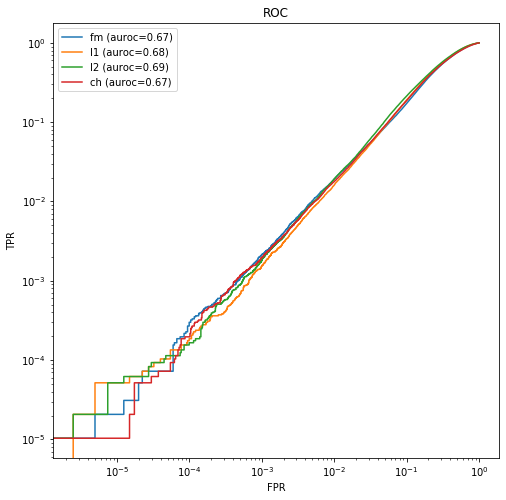

In [37]:
# loading data
print('loading data')
x, y = load_data(data_path, set='valid', type='mix', shuffle=True)
print('data shape:' + str(x.shape))
# take subset
if x.shape[0] > max_samples:
    print('taking subset')
    x, y = x[:max_samples], y[:max_samples]
print('data shape:' + str(x.shape))
print('running data preprocessor')
x = preprocessor.transform(x)

# plotting
scores = ad.compute_all_scores(x)
score_names = ['fm', 'l1', 'l2', 'ch']

fig, ax = plt.subplots(figsize=(8, 8))
for score, name in zip(scores, score_names):
    fpr, tpr, _ = roc_curve(y, score, pos_label=1)
    auroc = roc_auc_score(y, score)
    ax.loglog(fpr, tpr, label=name+' (auroc=%.2f)'%auroc)
    
ax.set_title('ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
plt.show()

loading data
data shape:(5935040, 23)
taking subset
data shape:(500000, 23)
running data preprocessor


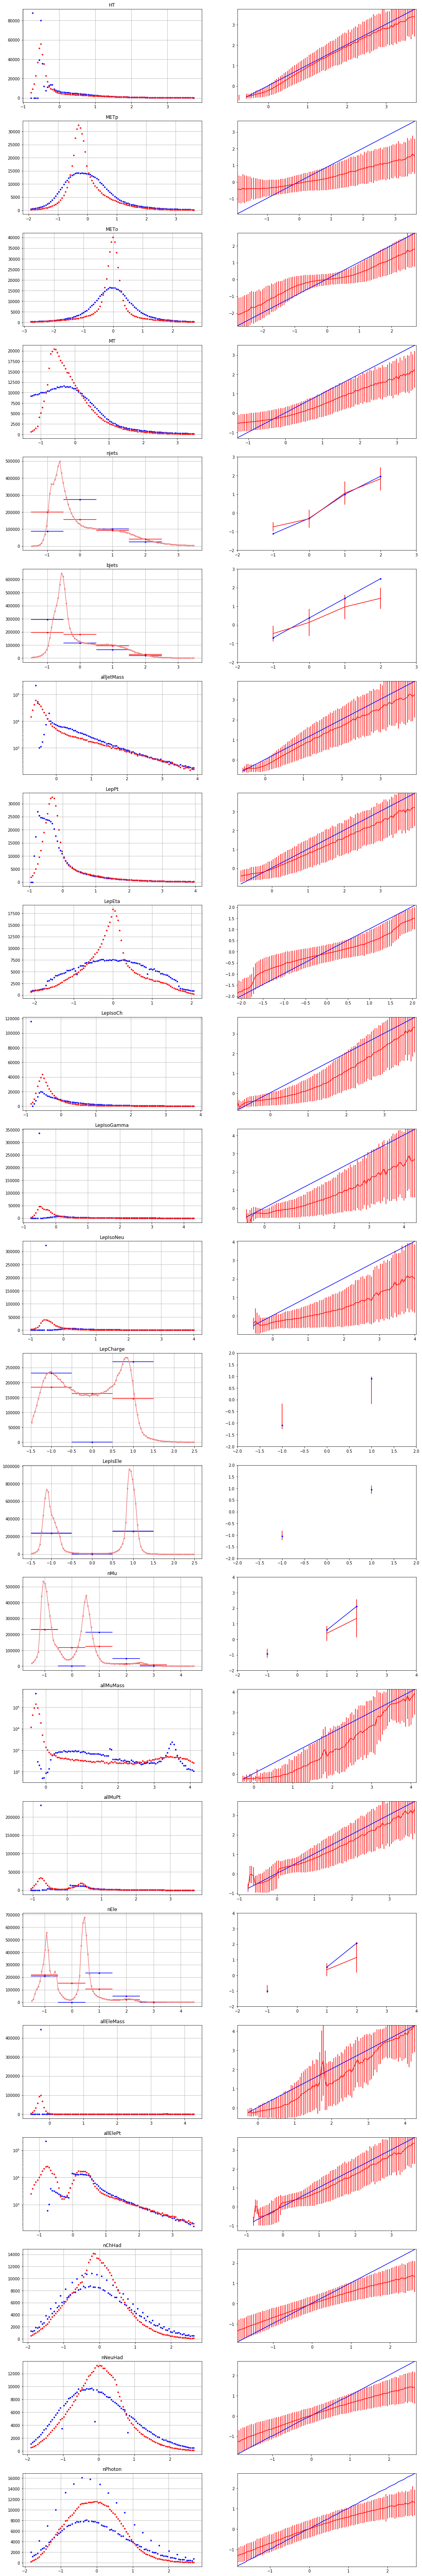

In [38]:
# loading data
print('loading data')
x, y = load_data(data_path, set='valid', type='mix', shuffle=True)
print('data shape:' + str(x.shape))
# take subset
if x.shape[0] > max_samples:
    print('taking subset')
    x, y = x[:max_samples], y[:max_samples]
print('data shape:' + str(x.shape))
print('running data preprocessor')
x = preprocessor.transform(x)

# plotting
plot_mode ={}
plot_mode.update(dict.fromkeys(['nJets', 'bJets','LepCharge','LepIsEle', 'nMu','nEle'],'discrete'))
plot_mode.update(dict.fromkeys(['LepIso', 'allJetMass','allMuMass', 'allMuPt''allEleMass', 'allElePt'],'log'))

x_recon = ad.recon(x)
f, ax_arr = plt.subplots(len(feature_names),2, figsize=(18,120))
for i, name in enumerate(feature_names):
    x_i = x[:,i]
    x_recon_i = x_recon[:,i]
        
    ax0 = ax_arr[i, 0]
    ax1 = ax_arr[i, 1]

    percentile = 1.
    histo_range = (np.minimum(np.percentile(x_recon_i, percentile),np.percentile(x_i, percentile)), 
                   np.maximum(np.percentile(x_recon_i, 100.-percentile),np.percentile(x_i, 100.-percentile)))
    
    
    ax0.set_title(name)
    ax0.grid()
    
    if name not in plot_mode.keys():
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax0.plot(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax0.plot(bin_edges[:-1], bin_content,'r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=n_bins,range=histo_range)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=n_bins,range=histo_range)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        
        ax1.plot(bin_edges[:-1], mean, color='b')
        ax1.errorbar(bin_edges[:-1], mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    elif plot_mode[name] == 'discrete':
        histo_range = (math.floor(histo_range[0]), math.ceil(histo_range[1]))
        
        bins_con = np.linspace(histo_range[0], histo_range[1], 100) + 0.5
        bins_dis = np.arange(histo_range[0], histo_range[1]) + 0.5
        n_bins_dis = len(bins_dis)
        
        # plot recon with 100 bins
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_con)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.plot(bincenters, 100./n_bins_dis *bin_content, color='lightcoral', marker='.')
        
        # plot recon and original discrete
        bin_content, bin_edges = np.histogram(x_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.errorbar(bincenters, bin_content, xerr = 0.5, fmt='b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.errorbar(bincenters, bin_content, xerr = 0.5, fmt='r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=bins_dis)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=bins_dis)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        
        ax1.plot(bincenters, mean,'.-b')
        ax1.errorbar(bincenters, mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    elif plot_mode[name] == 'log':
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax0.semilogy(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax0.semilogy(bin_edges[:-1], bin_content,'r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=n_bins,range=histo_range)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=n_bins,range=histo_range)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        
        ax1.plot(bin_edges[:-1], mean, color='b')
        ax1.errorbar(bin_edges[:-1], mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    else: raise Exception()
    
plt.show()